In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib

from datetime import datetime


import shutil
import pandas as pd

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
from skimage import exposure, img_as_float, color, io

# equalize_hist will equalise on the flatten image, hence, we should convert to grayscale first 
def AHE(img):
    img = color.rgb2gray(img)
    img = img / 255. 
#     img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)
    img_adapteq = exposure.equalize_hist(img)
    img_adapteq = img_adapteq * 255.
    return color.gray2rgb(img_adapteq).astype('uint8')


In [4]:
dir_str = "./nus-cs5242/"
shutil.rmtree(dir_str + "train_image/class", ignore_errors=True)
os.mkdir(dir_str + "train_image/class")
os.mkdir(dir_str + "train_image/class/0")
os.mkdir(dir_str + "train_image/class/1")
os.mkdir(dir_str + "train_image/class/2")

label = pd.read_csv(dir_str + "train_label.csv")
label_tupple = list(label.itertuples(index=False, name=None))



for i in range(len(label_tupple)):
    img_ext = str(label_tupple[i][0])
    img_class = str(label_tupple[i][1])
  
    shutil.copy(dir_str + "train_image/train_image/"+img_ext+".png", 
                dir_str + "train_image/class/"+img_class+"/"+img_ext+".png")
#     img = io.imread(dir_str + "train_image/train_image/"+img_ext+".png")
#     img = AHE(img)
#     io.imsave(dir_str + "train_image/class/"+img_class+"/"+img_ext+".png", img)

data_dir=dir_str + "train_image/class"
data_dir = pathlib.Path(data_dir)
print(data_dir)

nus-cs5242/train_image/class


In [5]:
# create tf datasets and load data, note: didn't use graysacle as all pretrained models over imagenet are RGB 
batch_size = 32
img_height = 512
img_width = 512
num_classes = 3

from tensorflow.keras.preprocessing.image import ImageDataGenerator


data_gen = ImageDataGenerator(horizontal_flip=False,
                              vertical_flip=False,
#                               samplewise_std_normalization=True,
                              zca_whitening=False,
                              rotation_range=10,
                              zoom_range=0.2,
                              brightness_range=(0.9,1.1),
                              validation_split=0.2,
                              fill_mode='wrap',
#                               preprocessing_function = AHE
                              ) 

train_gen = data_gen.flow_from_directory(data_dir, 
                                         target_size=(img_width,img_height),
#                                          color_mode='grayscale',
                                         class_mode='categorical',
                                         batch_size=batch_size, 
                                         subset='training',
                                         seed=123,
                                         shuffle=True)
val_gen = data_gen.flow_from_directory(data_dir, 
                                        target_size=(img_width, img_height),
#                                         color_mode='grayscale',
                                        class_mode='categorical',
                                        batch_size=batch_size, 
                                        subset='validation',
                                        seed=123,
                                        shuffle=True)
class_names = list(train_gen.class_indices.values())
# train_ds = tf.keras.preprocessing.image_dataset_from_directory(
#   data_dir,
#   #labels=train_labels,
#   #label_mode='int',
#   #color_mode='grayscale',
#   validation_split=0.2,
#   subset="training",
#   seed=123,
#   image_size=(img_height, img_width),
#   batch_size=batch_size)

# class_names = train_ds.class_names


Found 933 images belonging to 3 classes.
Found 231 images belonging to 3 classes.


In [6]:
# val_ds = tf.keras.preprocessing.image_dataset_from_directory(
#   data_dir,
#   #labels=train_labels,
#   #color_mode='grayscale',
#   #label_mode='int',
#   validation_split=0.2,
#   subset="validation",
#   seed=123,
#   image_size=(img_height, img_width),
#   batch_size=batch_size)

<Figure size 1440x1440 with 0 Axes>

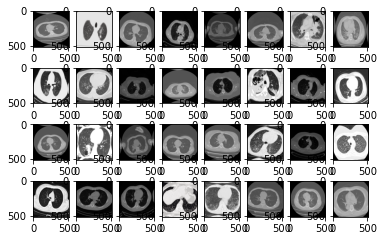

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
img, label = next(train_gen)

fig, axs = plt.subplots(batch_size//8, 8)

for i in range(batch_size):
    axs[i//8][i%8].imshow(img[i].astype("uint8"))


# for images, labels in train_ds.take(1):
#     for i in range(3):
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         #plt.title(class_names[labels[i]])
#         plt.axis("off")

### Test transfer learning model ResNet50

In [95]:
# Create the base model from the pre-trained model MobileNet V2
#base_model = tf.keras.applications.MobileNetV2(input_shape=(512,512,3),
#                                               include_top=False,
#                                               weights='imagenet')


from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications.resnet import preprocess_input, decode_predictions

base_model = ResNet101(input_shape=(512,512,3),
                                               include_top=False,
                                               pooling='avg',
                                               weights='imagenet')


In [96]:
#preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# preprocess_input = tf.keras.applications.resnet50.preprocess_input

In [97]:
# image_batch, label_batch = next(iter(train_ds))
# feature_batch = base_model(image_batch)
# print(feature_batch.shape)

In [98]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
# fine_tune_at = 143
# fine_tune_at = 165
# fine_tune_at = 177
fine_tune_at = 335
# fine_tune_at = 313

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False
    
for i, layer in enumerate(base_model.layers):
    print(i,layer.name,"-",layer.trainable)

Number of layers in the base model:  346
0 input_13 - False
1 conv1_pad - False
2 conv1_conv - False
3 conv1_bn - False
4 conv1_relu - False
5 pool1_pad - False
6 pool1_pool - False
7 conv2_block1_1_conv - False
8 conv2_block1_1_bn - False
9 conv2_block1_1_relu - False
10 conv2_block1_2_conv - False
11 conv2_block1_2_bn - False
12 conv2_block1_2_relu - False
13 conv2_block1_0_conv - False
14 conv2_block1_3_conv - False
15 conv2_block1_0_bn - False
16 conv2_block1_3_bn - False
17 conv2_block1_add - False
18 conv2_block1_out - False
19 conv2_block2_1_conv - False
20 conv2_block2_1_bn - False
21 conv2_block2_1_relu - False
22 conv2_block2_2_conv - False
23 conv2_block2_2_bn - False
24 conv2_block2_2_relu - False
25 conv2_block2_3_conv - False
26 conv2_block2_3_bn - False
27 conv2_block2_add - False
28 conv2_block2_out - False
29 conv2_block3_1_conv - False
30 conv2_block3_1_bn - False
31 conv2_block3_1_relu - False
32 conv2_block3_2_conv - False
33 conv2_block3_2_bn - False
34 conv2_block

In [99]:
import os
import tempfile

def add_regularization(model, regularizer=tf.keras.regularizers.l2(0.0001)):

    if not isinstance(regularizer, tf.keras.regularizers.Regularizer):
      print("Regularizer must be a subclass of tf.keras.regularizers.Regularizer")
      return model

    for layer in model.layers:
        for attr in ['kernel_regularizer']:
            if hasattr(layer, attr):
              setattr(layer, attr, regularizer)

    # When we change the layers attributes, the change only happens in the model config file
    model_json = model.to_json()

    # Save the weights before reloading the model.
    tmp_weights_path = os.path.join(tempfile.gettempdir(), 'tmp_weights.h5')
    model.save_weights(tmp_weights_path)

    # load the model from the config
    model = tf.keras.models.model_from_json(model_json)
    
    # Reload the model weights
    model.load_weights(tmp_weights_path, by_name=True)
    return model

base_model = add_regularization(base_model)
base_model.losses

[<tf.Tensor: shape=(), dtype=float32, numpy=0.011104983>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0016533287>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.002768356>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0053920746>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0021634072>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.001739698>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0035468226>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0021711823>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0021012241>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0037822502>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0022586933>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0025013199>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.005960113>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.009225838>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0042590657>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0032745916>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0065604215>,
 <

In [100]:
base_model.summary()

Model: "resnet101"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_13[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
__________________________________________________________________________________________

In [101]:
# global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# feature_batch_average = global_average_layer(feature_batch)
# print(feature_batch_average.shape)

In [102]:
# prediction_layer = tf.keras.layers.Dense(3)
# prediction_batch = prediction_layer(feature_batch_average)
# print(prediction_batch.shape)

In [103]:
# data_augmentation = tf.keras.Sequential([
# #   tf.keras.layers.experimental.preprocessing.Normalization(),
# #   tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),
#   tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
#   tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2)
# ])

In [104]:
# construct model 

# preprocess_input = tf.keras.applications.resnet50.preprocess_input

inputs = tf.keras.Input(shape=(512, 512, 3))
# x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x)
# x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
# x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dense(32, kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
# x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)

# x = tf.keras.layers.Dense(16, kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Activation('relu')(x)
# # x = tf.keras.layers.Dropout(0.3)(x)

x = tf.keras.layers.Dense(3, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
# outputs = prediction_layer(x)
model = tf.keras.Model(inputs, x)


In [109]:
# base_learning_rate = 0.001
#model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
#              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#              metrics=['accuracy'])
# step = tf.Variable(0, trainable=False)

lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
    [200, 500, 800], [ 0.003, 0.001, 0.0003, 0.00001])


model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=lr_schedule),
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01, from_logits=True ),
              metrics=['accuracy'])

# model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=lr_schedule),
#               loss=tf.keras.losses.CategoricalHinge(),
#               metrics=['accuracy'])

# model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule),
#               loss=tf.keras.losses.CategoricalHinge(),
#               metrics=['accuracy'])


In [110]:
model.summary()


Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 512, 512, 3)]     0         
_________________________________________________________________
tf_op_layer_strided_slice_7  [(None, 512, 512, 3)]     0         
_________________________________________________________________
tf_op_layer_BiasAdd_7 (Tenso [(None, 512, 512, 3)]     0         
_________________________________________________________________
resnet101 (Functional)       (None, 2048)              42658176  
_________________________________________________________________
dropout_7 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 32)                65568     
_________________________________________________________________
activation_7 (Activation)    (None, 32)              

In [111]:
class_weight = {0: 1.724358974,
                1: 1.,
                2: 1.713375796}

In [112]:
epochs=7
history = model.fit(
  train_gen,
  validation_data=val_gen,
  epochs=epochs,
  workers=8,
  steps_per_epoch=100,
  class_weight=class_weight
)
# history = model.fit_generator(
#     train_gen,
#     validation_data=val_gen,
#     epochs=epochs
# )

Epoch 1/7
100/100 [==============================] - 74s 741ms/step - loss: 1.7258 - accuracy: 0.8228 - val_loss: 1.4019 - val_accuracy: 0.8831
Epoch 2/7
100/100 [==============================] - 74s 740ms/step - loss: 1.6031 - accuracy: 0.9146 - val_loss: 1.3305 - val_accuracy: 0.9481
Epoch 3/7
100/100 [==============================] - 74s 744ms/step - loss: 1.5749 - accuracy: 0.9301 - val_loss: 1.3398 - val_accuracy: 0.9307
Epoch 4/7
100/100 [==============================] - 82s 817ms/step - loss: 1.5580 - accuracy: 0.9465 - val_loss: 1.3372 - val_accuracy: 0.9264
Epoch 5/7
100/100 [==============================] - 74s 739ms/step - loss: 1.5515 - accuracy: 0.9453 - val_loss: 1.3233 - val_accuracy: 0.9437
Epoch 6/7
100/100 [==============================] - 75s 751ms/step - loss: 1.5355 - accuracy: 0.9570 - val_loss: 1.3042 - val_accuracy: 0.9654
Epoch 7/7
100/100 [==============================] - 75s 745ms/step - loss: 1.5349 - accuracy: 0.9599 - val_loss: 1.3050 - val_accuracy:

In [116]:
# fine tuning, and train all layers
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 313
# fine_tune_at = 165
# fine_tune_at = 171

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False


model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=1e-5),
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01, from_logits=True ),
              metrics=['accuracy'])

epochs=3
history = model.fit(
  train_gen,
  validation_data=val_gen,
  epochs=epochs,
  workers=8,
  steps_per_epoch=100,
  class_weight=class_weight
)

Epoch 1/3
100/100 [==============================] - 79s 788ms/step - loss: 1.5396 - accuracy: 0.9609 - val_loss: 1.3068 - val_accuracy: 0.9654
Epoch 2/3
100/100 [==============================] - 75s 751ms/step - loss: 1.5387 - accuracy: 0.9586 - val_loss: 1.3034 - val_accuracy: 0.9654
Epoch 3/3
100/100 [==============================] - 76s 761ms/step - loss: 1.5326 - accuracy: 0.9667 - val_loss: 1.3124 - val_accuracy: 0.9610


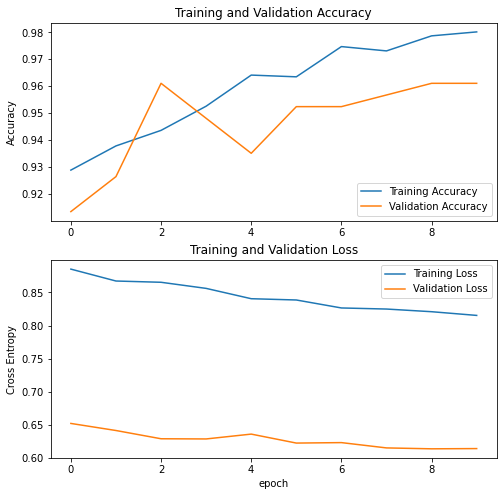

In [428]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
#plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [117]:
import os

output = []
    
test_folder = dir_str + "test_image/test_image"

for file in os.listdir(test_folder):
    filename = str(file).replace(".png","")
    image_path = os.path.join(test_folder, file)
    #print(filename, image_path)
    
#     img = keras.preprocessing.image.load_img(image_path, target_size=(img_height, img_width))
#     img_array = keras.preprocessing.image.img_to_array(img)
#     img_array = tf.expand_dims(img_array, 0) # Create a batch
#     print(img_array.shape)
    img = io.imread(image_path)
#     img = AHE(img)
    img = img[ np.newaxis, :]

    predictions = model.predict(img)

    score = predictions[0]
    label = class_names[np.argmax(score)]
#     label = class_names[np.argmax(score)]

    output.append([filename, label])
    #print(
    #    "This image most likely belongs to {} with a {:.2f} percent confidence."
    #    .format(class_names[np.argmax(score)], 100 * np.max(score))
    #)
    

In [118]:
results = pd.DataFrame(output, columns = ['ID' , 'Label']) 
results.ID = results.ID.astype(int)
results = results.sort_values(by="ID")

In [119]:
out_str = "submission_resnet50_" + datetime.today().strftime('%Y-%m-%d-%H-%M-%S') + ".csv"
results.to_csv(dir_str + out_str, index=False)

## Spot wrong images

In [250]:
i = 1

for img, label in next(val_gen).items(): #val_ds, train_ds

    pred = np.argmax(model.predict(img), axis=1)
#     print(pred)
#     print(label.numpy())

    
    wrong_idx = np.where(pred != label.numpy())[0]
    print(wrong_idx)
    
    if len(wrong_idx) < 1:
        continue
    
    plt.figure(i)
    f, axarr = plt.subplots(len(wrong_idx))
    
    if len(wrong_idx) == 1:
        plt.imshow(img[wrong_idx[0]].numpy().astype('uint8'))
    else:
        for j in range(len(wrong_idx)):
#             print(j)
            axarr[j].imshow(img[wrong_idx[j]].numpy().astype('uint8'))
    plt.show()
    i = i + 1

AttributeError: 'tuple' object has no attribute 'items'